# GNN V1

An attempt to use keras to build out a graph neural network and predict the user (label) using the dataset columns (features).

## Import and Initialize

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

2021-07-30 16:25:32.109041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-30 16:25:32.109086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


## Load Data

In [3]:
zync = pd.read_csv("data/zync_session_tracking_orc_20210625_all.csv")
print(f"Zync data shape: {zync.shape}")

sizmek = pd.read_csv("data/sizmek_bidstream_raw_20210625_10k.csv")
print(f"Sizmek data shape: {sizmek.shape}")

# Fix column headers
zync.columns = [i.split(".")[1] for i in zync.columns]
sizmek.columns = [i.split(".")[1] for i in sizmek.columns]

def make_smaller(df, frac):
    new_df = df.copy()
    new_df = new_df.sample(frac=frac, replace=False)
    return new_df

zync = make_smaller(zync, 0.1)
sizmek = make_smaller(sizmek, 0.1)

Zync data shape: (99999, 16)
Sizmek data shape: (10000, 16)


## Transform to Graph Format
**Goal:** Achieve this format here: https://keras.io/examples/graph/gnn_citations/
- Below are some examples of the current data structures:

In [4]:
sizmek.head(1)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
9853,57052281873774128,NaN,fa3e335a-6b70-45b0-a9fb-ac71d098a924:161377748...,35927,https://centurylink.net/?inc=11,https://centurylink.net/?inc=10,5419384.0,CO,80219,751.0,US,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,71.218.146.124,1624602605384,20210625


In [8]:
zync.head(1)

,session_id,client,client_id,remote_addr,referrer,user_agent_platform,user_agent_language,user_agent_browser,user_agent_string,user_agent_version,timestamp,geo_data,partner_data,session,consent_data,dt
89518,57896b96-7ca6-4348-83b6-b6a8790045f8:158789912...,disqus,c7af0rep17jm203,27.52.162.149,https://chinaq.tv/cn190731b/2.html,windows,NaN,chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,91.0.4472.114,1.624644e+09,"{""country"":""TW"",""subdivision"":""CHA"",""coordinat...",NaN,"{""clients"":{""appnexus"":null,""disqus"":""c7af0rep...","{""gdpr"":null,""gdpr_consent"":null}",2021-06-25-18


Ideally we want to get Source/Target interaction tuples. But what are the interactions in this dataset? There are no explicit sample-to-sample interactions here, it is all implicit via sample features such as URL, city, timestamp.

One thought: If two samples ARE the same user the features should match up (IP, user_agent, geo), with the exception of timestamps.

## Attempt 1: Do Some Loops
Let's create a 'connection' by looping through all rows for each row if there are any matching attribtutes in one of the select features (IP, user-agent, email, etc)

In [8]:
%%time

matching_cols = ["ip", "user_agent"]

def search_table(table, column, value):
    match_indices = []
    for ix, row in table.iterrows():
        if value == row[column]:
            match_indices.append(ix)
    print(f"Found {len(match_indices)} matches")


for ix, user_id in enumerate(sizmek["user_id"]):
    print(user_id)
    search_table(sizmek, "user_id", user_id)
    break

41527107883687338
Found 2 matches
CPU times: user 36.7 ms, sys: 0 ns, total: 36.7 ms
Wall time: 35.7 ms


### Result: Not Good!
It appears that a single search is on the order of `O(n^2)` complexity and for just 10k rows in this sample it takes ~300ms for a single iteration. This is completely infeasable for larger sizes. But that is something that can likely be fixed later on with pre-computed hashes. I'm thinking maybe a dictionary lookup where the dictionary key is the value we are searching for, and the dictionary value is the indices where this value is located. It can simply be updated as more rows are added.

## Attempt 2: Dictionary Lookup
There is no reason I should be iterating through the entire table for each value in the table, that's what hash lookups are for! So let's create a dictionary and use that to search for the value in each table.

In [9]:
%%time

def create_dict(table, col):
    table_dict = {}
    for ix, value in enumerate(table[col]):
        #print(value)
        if value in table_dict:
            table_dict[value].append(ix)
        else:
            table_dict[value] = [ix]
    return table_dict

def search_table(table, column):
    connections = []
    lookup_dict = create_dict(table, column)
    for ix, value in enumerate(table[column]):
        if value in lookup_dict:
            for item in lookup_dict[value]:
                connections.append((ix, item, column, value))
    connections = pd.DataFrame(
        connections, 
        columns=['source', 'target', 'column', 'value']
    )
    return connections

# Create three edge lists for some features
ip_graph = search_table(sizmek, "ip")
ua_graph = search_table(sizmek, "user_agent")
zip_graph = search_table(sizmek, "zip_code")

CPU times: user 186 ms, sys: 18.7 ms, total: 205 ms
Wall time: 203 ms


### Result: Very Good!
I can now search the entire table for three different features in only 24 seconds, this will be much more managable to scale up in the future when using millions of rows.

In [10]:
ip_graph.sample(3)

,source,target,column,value
1660,11,104,ip,71.218.146.124
11192,66,982,ip,71.218.146.124
116603,753,857,ip,71.218.146.124


### Example Plot of the Graph Network

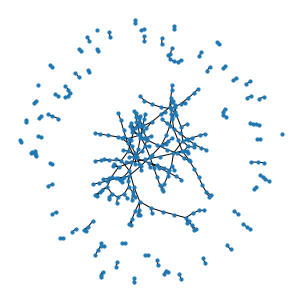

In [11]:
plt.figure(figsize=(4, 4))
g = nx.from_pandas_edgelist(zip_graph.sample(n=300))
nx.draw_spring(g, node_size=10)

## Create the Network

In [12]:
sizmek.head(2)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
5105,41527107883687338,NaN,NaN,19967,http://mob.app.com.eyecon.global,NaN,NaN,NaN,NaN,NaN,EG,Mozilla/5.0 (Linux; Android 10; JSN-L22 Build/...,dac52ca8-5d4a-430c-b0e8-b84b99c24f37,217.55.124.0,1624629780981,20210625
5509,49158092732748537,NaN,46acea72-4d42-4c25-83ae-e2a1ea8d1523:161655240...,19967,https://www.midwestliving.com/travel/ohio/akro...,NaN,5351549.0,CA,90247,803.0,US,Mozilla/5.0 (Linux; Android 10; moto g power (...,NaN,107.116.13.0,1624612096957,20210625


In [13]:
ip_graph.head(3)

,source,target,column,value
0,0,0,ip,217.55.124.0
1,0,209,ip,217.55.124.0
2,1,1,ip,107.116.13.0


In [14]:

feature_cols = ["account_id", "url", "referrer_url", "city_code", 
                "state_code", "dma_code", "country_code"]

feature_enc = OneHotEncoder(handle_unknown="ignore")
features_df = pd.DataFrame(
    feature_enc.fit_transform(sizmek[feature_cols]).toarray(), 
    columns=feature_enc.get_feature_names(feature_cols)
)
print(f"Unique features: {features_df.shape[1]}")

label_enc = LabelEncoder()
labels = label_enc.fit_transform(sizmek["zip_code"])
print(f"Unique labels: {max(labels)}")

Unique features: 451
Unique labels: 110


In [15]:
# Edges array (sparse adjacency matrix) of shape [2, num_edges]
edges = ip_graph[["source", "target"]].to_numpy().T
# Default edge weights to 1 (we don't have any in dataset)
edge_weights = tf.ones(shape=edges.shape[1])
# Node fatures array of shape [num_nodes, num_features]
node_features = tf.cast(features_df.to_numpy(), dtype=tf.dtypes.float32)
# Create the graph info with the above features
graph_info = (node_features, edges, edge_weights)

2021-07-23 16:13:24.614778: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-23 16:13:24.639601: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: UNKNOWN ERROR (801)
2021-07-23 16:13:24.639628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cube): /proc/driver/nvidia/version does not exist
2021-07-23 16:13:24.640758: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
from graph_network import GNNNodeClassifier, create_ffn

num_classes = len(sizmek["zip_code"].unique())

hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]).shape)

gnn_model.summary()

GNN output shape: (3, 111)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (1000, 32)                17452     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (1000, 32)                2368      
_________________________________________________________________
logits (Dense)               multiple                  3663      
Total params: 35,259
Trainable params: 33,525
Non-trainable params: 1,734
_________________________________________________________________


In [25]:
split_indices = train_test_split(range(len(features_df)))

# Features split
X_train = features_df.iloc[split_indices[0], :]
X_test = features_df.iloc[split_indices[1], :]

# Labels split
y_train = labels[split_indices[0]]
y_test = labels[split_indices[1]]

# HACKY FIX
X_train = np.array(split_indices[0])
y_train = pd.Series(data=y_train, index=split_indices[0])

X_test = np.array(split_indices[1])
y_test = pd.Series(data=y_test, index=split_indices[1])

In [21]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


history = run_experiment(gnn_model, X_train, y_train)

Epoch 1/300
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-07-23 16:13:59.889488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-23 16:13:59.891470: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600010000 Hz


3/3 [==============================] - 4s 526ms/step - loss: 4.7341 - acc: 0.0377 - val_loss: 4.4998 - val_acc: 0.3628
Epoch 2/300
3/3 [==============================] - 1s 383ms/step - loss: 4.2066 - acc: 0.2245 - val_loss: 4.1672 - val_acc: 0.3628
Epoch 3/300
3/3 [==============================] - 1s 382ms/step - loss: 3.5037 - acc: 0.3893 - val_loss: 3.5773 - val_acc: 0.4071
Epoch 4/300
3/3 [==============================] - 1s 375ms/step - loss: 2.9762 - acc: 0.4207 - val_loss: 3.0911 - val_acc: 0.5221
Epoch 5/300
3/3 [==============================] - 1s 366ms/step - loss: 2.5886 - acc: 0.4537 - val_loss: 3.0309 - val_acc: 0.4867
Epoch 6/300
3/3 [==============================] - 1s 371ms/step - loss: 2.5363 - acc: 0.4584 - val_loss: 3.1794 - val_acc: 0.3717
Epoch 7/300
3/3 [==============================] - 1s 359ms/step - loss: 2.5229 - acc: 0.4631 - val_loss: 3.2524 - val_acc: 0.3540
Epoch 8/300
3/3 [==============================] - 1s 380ms/step - loss: 2.3884 - acc: 0.4804 -

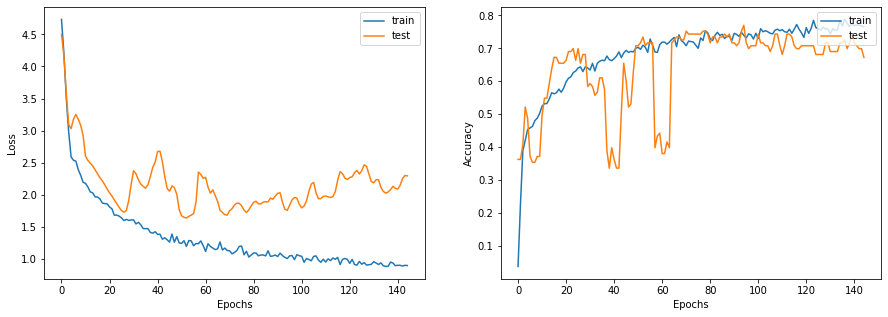

In [24]:
display_learning_curves(history)

In [26]:
_, test_accuracy = gnn_model.evaluate(x=X_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 82.8%
